In [167]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.exceptions import DataConversionWarning
import warnings

# Assuming X is your feature matrix and y is your target variable
# Make sure X contains missing values

# Disable DataConversionWarning related to missing data
warnings.filterwarnings("ignore", category=DataConversionWarning)

# Re-enable warnings for the rest of the code
warnings.filterwarnings("default", category=DataConversionWarning)


In [168]:
import numpy as np
from sklearn.model_selection import train_test_split


def bootstrap_sample(X, Y, sample_size=0.8, random_seed=None):
    """
    Function that creates a random sample from the given dataset.

    Parameters:
    - X: Features
    - Y: Labels
    - sample_size: Size of the sample to be created
    - random_seed: Seed for random number generation (optional)

    Returns:
    - X_sample: Random sample of features
    - Y_sample: Corresponding random sample of labels
    """
    subsample_X, _, subsample_Y, _ = train_test_split(X, Y, train_size=sample_size, random_state=random_seed)

    return subsample_X, subsample_Y


# DecisionTreeImputerClassifier
This code defines a custom machine learning classifier, DecisionTreeImputerClassifier, using scikit-learn. It combines a decision tree classifier with iterative imputation for handling missing data. The fit method performs bootstrap sampling (if enabled - will be usful in the random forest phase), imputes missing values, and then trains the decision tree classifier. The predict and predict_proba methods use the trained model to make predictions on new data after imputing missing values. This design aims to enhance the model's robustness in handling incomplete datasets.

In [169]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer as mice
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

class DecisionTreeImputerClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, random_state=42, bootstrap=False):
        self.tree = DecisionTreeClassifier(random_state=random_state)
        self.bootstrap = bootstrap
        self.random_state = random_state

    def fit(self, X, y, sample_weight=None, check_input=True) -> None:
        if self.bootstrap:
            X, y = bootstrap_sample(X, y)
        X = self.imputer.fit_transform(X)
        self.tree.fit(X, y, sample_weight=sample_weight, check_input=check_input)

    def predict(self, X, check_input=True):
        X = self.imputer.transform(X)
        return self.tree.predict(X, check_input=check_input)

    def predict_proba(self, X, check_input=True):
        X = self.imputer.transform(X)
        return self.tree.predict_proba(X, check_input=check_input)

class DecisionTreeMICEImputerClassifier(DecisionTreeImputerClassifier):
    def __init__(self, random_state=42, bootstrap=False):
        super().__init__(random_state=random_state, bootstrap=bootstrap)
        self.imputer = mice()

class DecisionTreeKNNImputerClassifier(DecisionTreeImputerClassifier):
    def __init__(self, random_state=42, bootstrap=False):
        super().__init__(random_state=random_state, bootstrap=bootstrap)
        self.imputer = KNNImputer()

class DecisionTreeSIMPLEImputerClassifier(DecisionTreeImputerClassifier):
    def __init__(self, random_state=42, bootstrap=False):
        super().__init__(random_state=random_state, bootstrap=bootstrap)
        self.imputer = SimpleImputer()


# BoostImputeRandomForestClassifier
This code defines a custom ensemble classifier named BoostImputeRandomForestClassifier. It combines the XGBoost classifier with a custom decision tree imputer, DecisionTreeImputerClassifier, designed to handle missing data. The ensemble is trained on the input data X and labels y. It utilizes XGBoost with multiple decision trees (controlled by n_estimators) where each tree internally uses the custom imputer. The predict and predict_proba methods make predictions using the trained ensemble. This approach aims to boost the model's performance by leveraging both ensemble learning and imputation strategies for handling incomplete datasets.

In [170]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
import xgboost as xgb

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer as mice
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import ConvergenceWarning
import warnings
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier

warnings.filterwarnings("ignore", category=ConvergenceWarning)


class BoostImputeRandomForestClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=5, criterion='gini', random_state=42):
        self.forest = None
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.random_state = random_state

    def fit_XGB_MICE(self, X, y) -> None:
        imputer = DecisionTreeMICEImputerClassifier(bootstrap=True).imputer
        imputed_X = imputer.fit_transform(X)
        self.forest = xgb.XGBClassifier(n_estimators=self.n_estimators, random_state=42)
        self.forest.fit(imputed_X, y)

    def fit_VOT_MICE(self, X, y) -> None:
        classifiers = [('MICE', DecisionTreeMICEImputerClassifier(bootstrap=True))]
        self.forest = VotingClassifier(estimators=classifiers, voting='soft')
        self.forest.fit(X, y)


    def fit_XGB_KNN(self, X, y) -> None:
        imputer = DecisionTreeKNNImputerClassifier(bootstrap=True).imputer
        imputed_X = imputer.fit_transform(X)
        self.forest = xgb.XGBClassifier(n_estimators=self.n_estimators, random_state=42)
        self.forest.fit(imputed_X, y)

    def fit_VOT_KNN(self, X, y) -> None:
        classifiers = [('KNN', DecisionTreeKNNImputerClassifier(bootstrap=True))]
        self.forest = VotingClassifier(estimators=classifiers, voting='soft')
        self.forest.fit(X, y)

    def fit_XGB_SIMPLE(self, X, y) -> None:
        imputer = DecisionTreeSIMPLEImputerClassifier(bootstrap=True).imputer
        imputed_X = imputer.fit_transform(X)
        self.forest = xgb.XGBClassifier(n_estimators=self.n_estimators, random_state=42)
        self.forest.fit(imputed_X, y)

    def fit_VOT_SIMPLE(self, X, y) -> None:
        classifiers = [('SIMPLE', DecisionTreeSIMPLEImputerClassifier(bootstrap=True))]
        self.forest = VotingClassifier(estimators=classifiers, voting='soft')
        self.forest.fit(X, y)


    def fit_ADA_MICE(self, X, y) -> None:
        DecisionTreeMICEImputerClassifier_ = DecisionTreeMICEImputerClassifier(bootstrap=True)
        imputed_X = DecisionTreeMICEImputerClassifier_.imputer.fit_transform(X)
        base_classifier = DecisionTreeMICEImputerClassifier_.tree
        self.forest = AdaBoostClassifier(base_classifier, random_state=42)
        self.forest.fit(imputed_X, y)


    def fit_ADA_KNN(self, X, y) -> None:
        DecisionTreeKNNImputerClassifier_ = DecisionTreeKNNImputerClassifier(bootstrap=True)
        imputed_X = DecisionTreeKNNImputerClassifier_.imputer.fit_transform(X)
        base_classifier = DecisionTreeKNNImputerClassifier_.tree
        self.forest = AdaBoostClassifier(base_classifier, random_state=42)
        self.forest.fit(imputed_X, y)


    def fit_ADA_SIMPLE(self, X, y) -> None:
        DecisionTreeSIMPLEImputerClassifier_ = DecisionTreeSIMPLEImputerClassifier(bootstrap=True)
        imputed_X = DecisionTreeSIMPLEImputerClassifier_.imputer.fit_transform(X)
        base_classifier = DecisionTreeSIMPLEImputerClassifier_.tree
        self.forest = AdaBoostClassifier(base_classifier, random_state=42)
        self.forest.fit(imputed_X, y)




    def predict(self, X, check_input=True):
        return self.forest.predict(X, check_input=check_input)

    def predict_proba(self, X):
        return self.forest.predict_proba(X)


# Task 1: Experimental Setup Overview
In this phase, we are setting up a comprehensive experiment to evaluate three different models on the Kaggle Corona dataset. The models under consideration are :
,

*   a custom ensemble classifier (BoostImputeRandomForestClassifier)
*   a standard XGBoost classifier
*   simple random forest with missing data imputed using two techniques:
    1.   k-nearest neighbors (KNN)
    2.   mean imputation

Each of those can be pipline, cell ot well writed process - as you like

here is an example of how i did the part of BoostImputeRandomForestClassifier for 1 expriment, mow i need to do 9 more time with diffrents splits of train and test.
from here - we need to complete the other methods as well so we can compare.

In [171]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

# Function to introduce NaN values randomly in a DataFrame
def introduce_nan(data, nan_fraction):
    nan_mask = np.random.rand(*data.shape) < nan_fraction
    data_with_nan = data.copy()
    data_with_nan[nan_mask] = np.nan
    return data_with_nan


# Load the breast cancer dataset
data = pd.read_csv("/content/corona.csv")
data['Linfociti'] = data['Linfociti'].astype('float64')
data['SESSO'] = data['SESSO'].astype('string')
X = data.drop(['TARGET','SESSO'], axis=1)
y = data['TARGET']
data

roc_auc_scores = []
# for _ in range(10):
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifier = BoostImputeRandomForestClassifier()

# Train the classifier on the training set
classifier.fit_ADA_MICE(X_train, y_train)
imputer=mice()
X_test_=imputer.fit_transform(X_test)
# Predict the probabilities on the test set
y_probs = classifier.predict_proba(X_test_)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_probs)
print(auc_score)
roc_auc_scores.append(auc_score)

0.6523809523809525


# Task 2: Models Training and Evaluation
The next step involves training and evaluating the models on the original dataset. This phase aims to establish baseline performance for each model before any imputation strategy is applied.
for set the ground for all of use - lets go with 80-20 ratio of train test split in each exporimnet.
we need to run each on the "fit-predict" phase 10 times so we can compare it well with the hypothesis testing in the next phase.
We will record the ROC-AUC scores for comparison in later stages.

In [172]:
roc_auc_scores_mice_xgb = []
roc_auc_scores_knn_xgb = []
roc_auc_scores_simple_xgb = []
roc_auc_scores_mice_vot = []
roc_auc_scores_knn_vot = []
roc_auc_scores_simple_vot = []
roc_auc_scores_mice_ada = []
roc_auc_scores_knn_ada = []
roc_auc_scores_simple_ada = []
roc_auc_scores_benchmark = []
splits=[]
for i in range(10):
    random_state = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    splits.append((X_train, X_test, y_train, y_test))

for (X_train_, X_test_, y_train_, y_test_) in splits :
   X_train, X_test, y_train, y_test =X_train_, X_test_, y_train_, y_test_
   classifier = BoostImputeRandomForestClassifier()
   classifier.fit_XGB_MICE(X_train, y_train)
   y_probs = classifier.predict_proba(X_test)[:, 1]
   auc_score = roc_auc_score(y_test, y_probs)
   roc_auc_scores_mice_xgb.append(auc_score)


for (X_train_, X_test_, y_train_, y_test_) in splits :
   X_train, X_test, y_train, y_test =X_train_, X_test_, y_train_, y_test_
   classifier = BoostImputeRandomForestClassifier()
   classifier.fit_XGB_KNN(X_train, y_train)
   y_probs = classifier.predict_proba(X_test)[:, 1]
   auc_score = roc_auc_score(y_test, y_probs)
   roc_auc_scores_knn_xgb.append(auc_score)


for (X_train_, X_test_, y_train_, y_test_) in splits :
   X_train, X_test, y_train, y_test =X_train_, X_test_, y_train_, y_test_
   classifier = BoostImputeRandomForestClassifier()
   classifier.fit_XGB_SIMPLE(X_train, y_train)
   y_probs = classifier.predict_proba(X_test)[:, 1]
   auc_score = roc_auc_score(y_test, y_probs)
   roc_auc_scores_simple_xgb.append(auc_score)


for (X_train_, X_test_, y_train_, y_test_) in splits :
   X_train, X_test, y_train, y_test =X_train_, X_test_, y_train_, y_test_
   classifier = BoostImputeRandomForestClassifier()
   classifier.fit_VOT_MICE(X_train, y_train)
   y_probs = classifier.predict_proba(X_test)[:, 1]
   auc_score = roc_auc_score(y_test, y_probs)
   roc_auc_scores_mice_vot.append(auc_score)


for (X_train_, X_test_, y_train_, y_test_) in splits :
   X_train, X_test, y_train, y_test =X_train_, X_test_, y_train_, y_test_
   classifier = BoostImputeRandomForestClassifier()
   classifier.fit_VOT_KNN(X_train, y_train)
   y_probs = classifier.predict_proba(X_test)[:, 1]
   auc_score = roc_auc_score(y_test, y_probs)
   roc_auc_scores_knn_vot.append(auc_score)


for (X_train_, X_test_, y_train_, y_test_) in splits :
   X_train, X_test, y_train, y_test =X_train_, X_test_, y_train_, y_test_
   classifier = BoostImputeRandomForestClassifier()
   classifier.fit_VOT_SIMPLE(X_train, y_train)
   y_probs = classifier.predict_proba(X_test)[:, 1]
   auc_score = roc_auc_score(y_test, y_probs)
   roc_auc_scores_simple_vot.append(auc_score)

for (X_train_, X_test_, y_train_, y_test_) in splits :
   X_train, X_test, y_train, y_test =X_train_, X_test_, y_train_, y_test_
   classifier = BoostImputeRandomForestClassifier()
   classifier.fit_ADA_MICE(X_train, y_train)
   imputer=mice()
   X_test_=imputer.fit_transform(X_test)
   y_probs = classifier.predict_proba(X_test_)[:, 1]
   auc_score = roc_auc_score(y_test, y_probs)
   roc_auc_scores_mice_ada.append(auc_score)

for (X_train_, X_test_, y_train_, y_test_) in splits :
   X_train, X_test, y_train, y_test =X_train_, X_test_, y_train_, y_test_
   classifier = BoostImputeRandomForestClassifier()
   classifier.fit_ADA_KNN(X_train, y_train)
   imputer=KNNImputer()
   X_test_=imputer.fit_transform(X_test)
   y_probs = classifier.predict_proba(X_test_)[:, 1]
   auc_score = roc_auc_score(y_test, y_probs)
   roc_auc_scores_knn_ada.append(auc_score)


for (X_train_, X_test_, y_train_, y_test_) in splits :
   X_train, X_test, y_train, y_test =X_train_, X_test_, y_train_, y_test_
   classifier = BoostImputeRandomForestClassifier()
   classifier.fit_ADA_SIMPLE(X_train, y_train)
   imputer=SimpleImputer()
   X_test_=imputer.fit_transform(X_test)
   y_probs = classifier.predict_proba(X_test_)[:, 1]
   auc_score = roc_auc_score(y_test, y_probs)
   roc_auc_scores_simple_ada.append(auc_score)

for (X_train_, X_test_, y_train_, y_test_) in splits :
   X_train, X_test, y_train, y_test =X_train_, X_test_, y_train_, y_test_
   classifier = xgb.XGBClassifier(n_estimators=5, random_state=42)
   classifier.fit(X_train, y_train)
   y_probs = classifier.predict_proba(X_test_)[:, 1]
   auc_score = roc_auc_score(y_test, y_probs)
   roc_auc_scores_benchmark.append(auc_score)

roc_auc_scores_mice_xgb_avg = np.mean(roc_auc_scores_mice_xgb)
roc_auc_scores_knn_xgb_avg = np.mean(roc_auc_scores_knn_xgb)
roc_auc_scores_simple_xgb_avg = np.mean(roc_auc_scores_simple_xgb)
roc_auc_scores_mice_vot_avg = np.mean(roc_auc_scores_mice_vot)
roc_auc_scores_knn_vot_avg = np.mean(roc_auc_scores_knn_vot)
roc_auc_scores_simple_vot_avg = np.mean(roc_auc_scores_simple_vot)
roc_auc_scores_mice_ada_avg = np.mean(roc_auc_scores_mice_ada)
roc_auc_scores_knn_ada_avg = np.mean(roc_auc_scores_knn_ada)
roc_auc_scores_simple_ada_avg = np.mean(roc_auc_scores_simple_ada)
roc_auc_scores_benchmark_avg = np.mean(roc_auc_scores_benchmark)



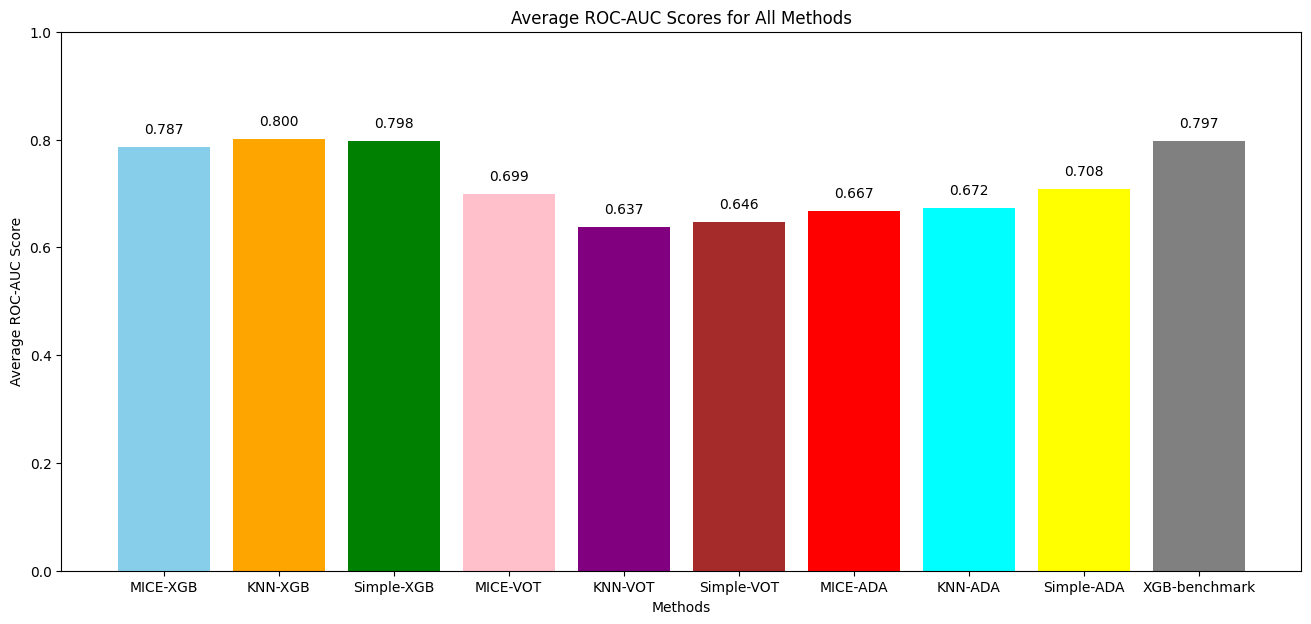

In [173]:
import numpy as np
import matplotlib.pyplot as plt

methods = ['MICE-XGB', 'KNN-XGB', 'Simple-XGB', 'MICE-VOT', 'KNN-VOT', 'Simple-VOT', 'MICE-ADA', 'KNN-ADA', 'Simple-ADA', 'XGB-benchmark']
average_roc_auc_scores = [roc_auc_scores_mice_xgb_avg, roc_auc_scores_knn_xgb_avg, roc_auc_scores_simple_xgb_avg,
                           roc_auc_scores_mice_vot_avg, roc_auc_scores_knn_vot_avg, roc_auc_scores_simple_vot_avg,
                           roc_auc_scores_mice_ada_avg, roc_auc_scores_knn_ada_avg, roc_auc_scores_simple_ada_avg, roc_auc_scores_benchmark_avg]

colors = ['skyblue', 'orange', 'green', 'pink', 'purple', 'brown', 'red', 'cyan', 'yellow', 'grey']

plt.figure(figsize=(16, 7))
bars = plt.bar(methods, average_roc_auc_scores, color=colors)

for bar, score in zip(bars, average_roc_auc_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{score:.3f}', ha='center', va='bottom')

plt.title('Average ROC-AUC Scores for All Methods')
plt.xlabel('Methods')
plt.ylabel('Average ROC-AUC Score')
plt.ylim([0, 1])
plt.show()


# Task 3: Mann-Whitney U Testing
To assess statistical significance, we employ the Mann-Whitney U test, a non-parametric method that directly compares ROC-AUC score distributions for each model pair. This test is selected for its robustness and ability to evaluate differences without relying on normality assumptions. Significance is determined with a set threshold of 0.05.

In [174]:
from scipy.stats import mannwhitneyu
import itertools

all_scores = [
    roc_auc_scores_mice_xgb, roc_auc_scores_knn_xgb, roc_auc_scores_simple_xgb,
    roc_auc_scores_mice_vot, roc_auc_scores_knn_vot, roc_auc_scores_simple_vot,
    roc_auc_scores_mice_ada, roc_auc_scores_knn_ada, roc_auc_scores_simple_ada,
    roc_auc_scores_benchmark
]

# Create combinations of pairs of lists
pairs = list(itertools.combinations(range(len(all_scores)), 2))

# Initialize a matrix to store p-values
num_methods = len(all_scores)
p_value_matrix = np.zeros((num_methods, num_methods))

# Calculate p-values for each pair using Mann-Whitney U test
for pair in pairs:
    i, j = pair
    stat, p_value = mannwhitneyu(all_scores[i], all_scores[j])
    p_value_matrix[i, j] = p_value
    p_value_matrix[j, i] = p_value  # The matrix is symmetric

# Display the p-value matrix
print("P-value Matrix:")
print(p_value_matrix)

# Significance level
significance_level = 0.05

# Identify and print significant pairs
significant_pairs = np.argwhere(p_value_matrix < significance_level)

for pair in significant_pairs:
    model_i, model_j = pair
    if model_i != model_j:
        print(f"Reject the null hypothesis for models {model_i} and {model_j}. There is a significant difference.")


P-value Matrix:
[[0.00000000e+00 5.20522883e-01 5.70750388e-01 1.13296967e-02
  4.39638753e-04 1.00797624e-03 5.80060371e-04 5.14218362e-03
  9.10849640e-03 7.91336780e-01]
 [5.20522883e-01 0.00000000e+00 8.50106739e-01 2.82727209e-03
  2.46128128e-04 1.82671791e-04 1.81651146e-04 1.00797624e-03
  2.82727209e-03 6.77584958e-01]
 [5.70750388e-01 8.50106739e-01 0.00000000e+00 5.79535854e-03
  2.46128128e-04 4.39638753e-04 4.37454921e-04 1.31494467e-03
  4.58639208e-03 8.50106739e-01]
 [1.13296967e-02 2.82727209e-03 5.79535854e-03 0.00000000e+00
  6.40221013e-02 1.04109890e-01 3.44522779e-01 4.05502300e-01
  7.91336780e-01 9.10849640e-03]
 [4.39638753e-04 2.46128128e-04 2.46128128e-04 6.40221013e-02
  0.00000000e+00 7.33729996e-01 3.44522779e-01 3.44704222e-01
  2.57480808e-02 3.29838521e-04]
 [1.00797624e-03 1.82671791e-04 4.39638753e-04 1.04109890e-01
  7.33729996e-01 0.00000000e+00 5.20366021e-01 7.33729996e-01
  4.51545696e-02 4.39638753e-04]
 [5.80060371e-04 1.81651146e-04 4.37454921